### single label classification text using pytorch lightning training of transformers
pl boilerplate : https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

In [1]:
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval
import pickle

import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
%matplotlib inline

# pytorch libraries
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import Dataset, DataLoader


import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer, seed_everything
from torchmetrics.functional import accuracy, f1_score, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

/root/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


'Quadro RTX 6000'

In [2]:
#load train, test dataset
train_filename = "train_dropdups.csv"
val_filename = "validation_dropdups.csv"
test_filename = "test_dropdups.csv"

train_df = pd.read_csv(train_filename)
val_df = pd.read_csv(val_filename)
test_df = pd.read_csv(test_filename)

train_df

,TYPE,DOCUMENT_CONTENT,DOCUMENT_CLASS
0,TRAIN,Great News to All Vape Lovers Vapefanz has res...,2
1,TRAIN,Vaprcase 2 Review: Lifegrabber√¢‚Ç¨‚Ñ¢s Soluti...,1
2,TRAIN,i bought 2 boxes and both has 0.8 and 1.2,1
3,TRAIN,pod Fundamentals Explained vanilla - When rega...,1
4,TRAIN,Pretty fun time streaming some VALORANT with m...,2
...,...,...,...
4835,TRAIN,√¢≈° √Ø¬∏¬è√∞≈∏¬ê¬¢ TURTLE JUICE √∞≈∏¬ê¬¢√¢≈° ...,1
4836,TRAIN,Dude check out blankz pods. They make a Juul c...,1
4837,TRAIN,Koko prem vape device here√∞≈∏‚Äò‚Ä∞0562220852...,1
4838,TRAIN,Hero of the day myblu capsules We tell there a...,2


In [3]:
print('Unique content: ', train_df['DOCUMENT_CONTENT'].nunique() == train_df.shape[0])
print('Null values: ', train_df.isnull().values.any())
print('Average sentence length: ', train_df['DOCUMENT_CONTENT'].str.split().str.len().mean())
print('Std deviation sentence length: ', train_df['DOCUMENT_CONTENT'].str.split().str.len().std())

Unique content:  True
Null values:  False
Average sentence length:  36.20702479338843
Std deviation sentence length:  25.99536799296542


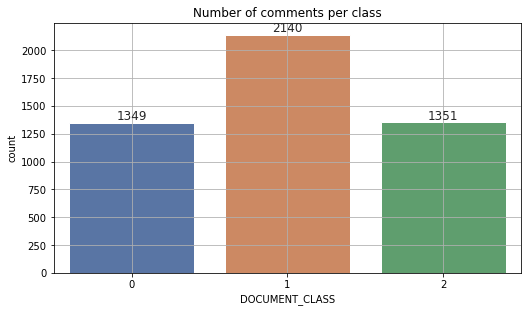

In [4]:
# make a frequency plot for each category

category_counts = {}
for doc_type in train_df['DOCUMENT_CLASS']:
    if doc_type not in category_counts.keys():
        category_counts[doc_type] = 1
    else:
        category_counts[doc_type] += 1

plt.rcParams["figure.figsize"] = [7.50, 4.50]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
# train_df['DOCUMENT_CLASS'].value_counts().plot(ax=ax, kind='bar')

sns.set(style="ticks")
ax = sns.countplot(x='DOCUMENT_CLASS', data=train_df)
ax.bar_label(ax.containers[0])
plt.title("Number of comments per class")
plt.grid()
plt.show()


In [5]:
# extract out data content column and labels
X_train = train_df["DOCUMENT_CONTENT"]
X_val = val_df["DOCUMENT_CONTENT"]
X_test = test_df["DOCUMENT_CONTENT"]
y_train = train_df["DOCUMENT_CLASS"].values
y_val = val_df["DOCUMENT_CLASS"].values
y_test = test_df["DOCUMENT_CLASS"].values

# seeds
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

X_train.shape

(4840,)

In [6]:
# converting y into one hot vectors like multiclass

# encoded_dict = {‘0’:[1,0,0],’1’:[0,1,0], ‘2’:[0,0,1]}
name_classes = ['0','1','2']
num_classes = len(category_counts.keys())

y_train = np.eye(num_classes)[y_train]
y_val = np.eye(num_classes)[y_val]
y_test = np.eye(num_classes)[y_test]
y_train

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [7]:
# Clean data
def rm_non_ascii(text):
    # remeove non-ascii characters
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    # remove digits and underscores
    text = re.sub(r'[0-9_:\-\'\"\[\]?/+=.,;!@#$%^&*()<>|{}~]+',' ', text)
    # removes mutiple spaces
    text = " ".join(text.split())
    return text

print("Sample X before cleaning:", X_train[1])
X_train = X_train.apply(rm_non_ascii)
X_val = X_val.apply(rm_non_ascii)
X_test = X_test.apply(rm_non_ascii)
print("Sample X after cleaning:", X_train[1])



Sample X before cleaning: Vaprcase 2 Review: Lifegrabber√¢‚Ç¨‚Ñ¢s Solution to Protect Pax 2 Vaporizers ...#cannabisnews #cannabis #hemp #CBD
Sample X after cleaning: Vaprcase Review Lifegrabber s Solution to Protect Pax Vaporizers cannabisnews cannabis hemp CBD


In [8]:
# stemming to bring base word form. lemmatisation not req

def stemming(text):
    ps = PorterStemmer()

    words = word_tokenize(text)
    for i in range(len(words)):
        words[i] = ps.stem(words[i])
    text = " ".join(words)
    return text
        
print("Sample X before stemming:", X_train[1])    
# X_train = X_train.apply(stemming)
# X_val = X_val.apply(stemming)
# X_test = X_test.apply(stemming)
print("Sample X after stemming:", X_train[1])



Sample X before stemming: Vaprcase Review Lifegrabber s Solution to Protect Pax Vaporizers cannabisnews cannabis hemp CBD
Sample X after stemming: Vaprcase Review Lifegrabber s Solution to Protect Pax Vaporizers cannabisnews cannabis hemp CBD


In [9]:
def show_metrics(y_test, y_pred, title="Classifier"):
    # Calculate confusion matrix

    matrix=confusion_matrix(y_test, y_pred)
    cm_labeled=pd.DataFrame(matrix,index=['0','1','2'],columns=['0','1','2'])
    # True Labels in y-axis/rows. Precision = TP/(TP+FP)
#     print("Confusion Matrix:\n", cm_labeled)
    sns.heatmap(cm_labeled, annot=True)
    plt.show()

    # Get the accuracy
    print('\nAccuracy: {:.5f}\n'.format(accuracy_score(y_test, y_pred)))

    # Print the classification report
    print(f'Classification Report {title}:')
#     TODO fix target names dynamic
    print(classification_report(y_test, y_pred, target_names=['DOC_0', 'DOC_1', 'DOC_2']))
    return accuracy_score(y_test, y_pred)

### To utilize pytorch-lightning’s Lightning Module class
1) train_dataloader, (X. y_label, attention_mask, token_type_ids)

2) training_step and 

3) configure_optimizers

`VapeSLC train.csv dataset`

In [10]:
class VapeSLCDataset(Dataset):
    
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer,
#         tokenizer: BertTokenizer, RobertaTokenizer
        max_token_len: int = 100,
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        content = data_row['DOCUMENT_CONTENT'] # X "hi bro vape"
        labels = data_row['DOCUMENT_CLASS'] # y [0,1,0] given as label
        labels = np.eye(num_classes)[labels]

        encoding = self.tokenizer.encode_plus(
            content,
            max_length=self.max_token_len,
            padding='max_length',
            truncation=True,
            pad_to_max_length=True, 
            add_special_tokens=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # BertForSequenceClassification needs input_ids, attention_mask, token_type_ids
        return dict(
            content=content,
            input_ids=encoding['input_ids'].flatten(),
            attention_mask=encoding['attention_mask'].flatten(),
            labels=torch.FloatTensor(labels)
        )

In [11]:
# wrap our custom dataset into a LightningDataModule. 
# encapsulates all data loading logic and returns the necessary data loaders.
# DataLoader helps save on memory during training, entire dataset does not need to be loaded into memory
class VapeSLCDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        val_df: pd.DataFrame,
        tokenizer,
        batch_size=8,
        max_token_len=128
    ):
        super().__init__()

        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
    
    def setup(self, stage=None):
        self.train_dataset = VapeSLCDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )
        self.test_dataset = VapeSLCDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )
        self.val_dataset = VapeSLCDataset(
            self.val_df,
            self.tokenizer,
            self.max_token_len
        )
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=2
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=2
        )

In [12]:
# Model pack everything in a LightningModule
# points of interest are the way we configure the optimizers and calculating the area under ROC
class SingleLabelClassifier(pl.LightningModule):
    def __init__(
        self,
        num_classes: int,
        num_training_steps=None,
        num_warmup_steps=None,
        model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_classes),
        # self.model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_classes),
        criterion = BCEWithLogitsLoss()
        
    ):
        super().__init__()
        self.model = model
        self.num_training_steps = num_training_steps
        self.num_warmup_steps = num_warmup_steps
        self.criterion = criterion
        
    def forward(self, input_ids, attention_mask, labels=None):
        output_model = self.model(input_ids, attention_mask=attention_mask)
        logits = output_model[0]
#         loss_func = BCEWithLogitsLoss() 
    
        loss = 0
        if labels is not None:
            #convert labels to float for calculation
            loss = self.criterion(logits.view(-1,num_classes),labels.type_as(logits).view(-1,num_classes)) 

#       TODO:check this outputs or logits
        return loss, logits

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
#         return loss
        return {"loss": loss, "predictions": outputs, "labels": labels}
    
    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
#         return loss
        return {"loss": loss, "predictions": outputs, "labels": labels}
    
    
    def training_epoch_end(self, outputs):
        labels = []
        predictions = []
        for output in outputs:
          for out_labels in output["labels"].detach().cpu():
            labels.append(out_labels)
          for out_predictions in output["predictions"].detach().cpu():
            predictions.append(out_predictions)
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        for i, name in enumerate(name_classes):
          class_roc_auc = auroc(predictions[:, i], labels[:, i])
          self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
    
    def configure_optimizers(self):
        # setting custom optimization parameters. may implement a scheduler here as well.
        param_optimizer = list(model.named_parameters())
        # print("named parameters: ", param_optimizer)
        no_decay = ['bias', 'gamma', 'beta']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.0}
        ]
        
        optimizer = AdamW(self.parameters(), lr=2e-5)
#TODO         optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5,correct_bias=True, )
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.num_warmup_steps,
            num_training_steps=self.num_training_steps
        )
        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=scheduler,
                interval='step'
            )
        )


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size":

/root/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


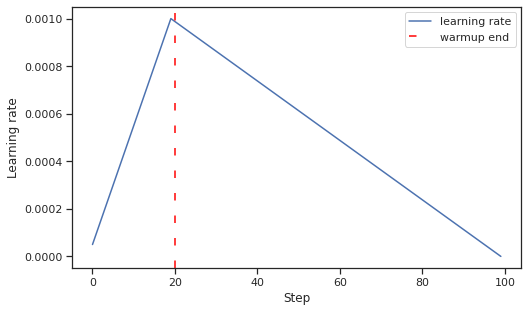

In [13]:
# Linear learning rate scheduling over training steps

dummy_model = torch.nn.Linear(2, 1)
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)
warmup_steps = 20
total_training_steps = 100
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)
learning_rate_history = []
for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [14]:
# sample item from the dataset

# BERT tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
# # XLNet tokenizer
# tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False) 
# # RoBERTa tokenizer
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)
# MPNet
tokenizer = MPNetTokenizer.from_pretrained("microsoft/mpnet-base")


MAX_TOKEN_COUNT = 200
train_dataset = VapeSLCDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[1]
print("Got datatype: ",sample_item.keys())
print(f"{sample_item['content']}  \n{sample_item['labels']} --->")
print(f"input encoding : {sample_item['input_ids']}\nattention mask : {sample_item['attention_mask']} ")

loading file https://huggingface.co/microsoft/mpnet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a24bf5e4745b7a1fc2af13b404a440cabd4e3bbf3dfead89248ca3cb56cff11.98b26f9c960899aa0e99c10a12750104e467743b3b460b79fa7d76907549319b
loading file https://huggingface.co/microsoft/mpnet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/microsoft/mpnet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/microsoft/mpnet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/microsoft/mpnet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a18491990fc4d73f8f8bc4048f33f3210d3bbfa158c7073345c34a0f69d55812.12e86a96e35480ba3a7aa8123711b61621201f63ce5060bfe0f58b932f7427c5
Model config MPNetConfig {
  "_name_or_path": "microsoft/mpnet-base",
  "architectures": [
    "MPNetForMaskedLM"
  ],
  "attenti

Got datatype:  dict_keys(['content', 'input_ids', 'attention_mask', 'labels'])
Vaprcase 2 Review: Lifegrabber√¢‚Ç¨‚Ñ¢s Solution to Protect Pax 2 Vaporizers ...#cannabisnews #cannabis #hemp #CBD  
tensor([0., 1., 0.]) --->
input encoding : tensor([    0, 12440, 18102, 18386,  1020,  3323,  1028,  2170, 17647, 29329,
        30131, 29649,  1526,  1043, 29655,  1526,  1054, 29649,  2019,  5580,
         2004,  4051,  6647,  2599,  1020, 20068, 17633,  2019,  1016,  1016,
         1016,  1005, 17989,  2642,  9337,  1005, 17989,  1005, 19614,  2365,
         1005, 17328,  2098,     2,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,   

In [15]:
N_EPOCHS = 2
BATCH_SIZE = 64
data_module = VapeSLCDataModule(
    train_df=train_df,
    test_df=test_df,
    val_df=val_df,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)


In [16]:
# number of training steps per epoch = number of training examples / batch size
# total training steps = training steps per epoch * number of epochs

steps_per_epoch=len(train_df) # BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps


# BERT
# model_name = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_classes)
# XLNet:
# model_name = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_classes)
# RoBERTa:
# model_name = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_classes)
# MPNet 
model_name = MPNetForSequenceClassification.from_pretrained("microsoft/mpnet-base", num_labels=num_classes)


# Model Init
model = SingleLabelClassifier(
    num_classes=num_classes,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps,
    model=model_name
)
model.cuda()

loading configuration file https://huggingface.co/microsoft/mpnet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a18491990fc4d73f8f8bc4048f33f3210d3bbfa158c7073345c34a0f69d55812.12e86a96e35480ba3a7aa8123711b61621201f63ce5060bfe0f58b932f7427c5
Model config MPNetConfig {
  "architectures": [
    "MPNetForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "mpnet",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.20.1",
  "vocab_size": 30527
}

loading weigh

SingleLabelClassifier(
  (model): MPNetForSequenceClassification(
    (mpnet): MPNetModel(
      (embeddings): MPNetEmbeddings(
        (word_embeddings): Embedding(30527, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): MPNetEncoder(
        (layer): ModuleList(
          (0): MPNetLayer(
            (attention): MPNetAttention(
              (attn): MPNetSelfAttention(
                (q): Linear(in_features=768, out_features=768, bias=True)
                (k): Linear(in_features=768, out_features=768, bias=True)
                (v): Linear(in_features=768, out_features=768, bias=True)
                (o): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_aff

### Train Model
##### Training with PyTorch Lightning, we can build a standard pipeline and train (almost?) every model.

Use at least 3 components:
- Checkpointing that saves the best model (based on validation loss):
- Log the progress in TensorBoard
- Start the training process

In [17]:
import os
output_dir = 'checkpoints'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
dirpath = os.path.join(os.getcwd(), output_dir)

# checkpoint
checkpoint_callback = ModelCheckpoint(
  dirpath=dirpath,
  filename="bert-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

# logger
logger = TensorBoardLogger("lightning_logs", name="single-label-classifier")

# early stopping triggers when the loss hasn’t improved for the last 2 epochs
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)


# train!
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  auto_lr_find=True,
  progress_bar_refresh_rate=30
)

/root/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:151: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f9ae6d72520>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f9ae6d72520>)`.
  rank_zero_deprecation(
/root/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True

In [18]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type                           | Params
-------------------------------------------------------------
0 | model     | MPNetForSequenceClassification | 109 M 
1 | criterion | BCEWithLogitsLoss              | 0     
-------------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.955   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/root/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [19]:
# trainer.test()


In [20]:
# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs

### Prediction

In [21]:
# load the best val_loss model
trained_model = SingleLabelClassifier.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  num_classes=num_classes
)
trained_model.eval()
trained_model.freeze()

RuntimeError: Error(s) in loading state_dict for SingleLabelClassifier:
	Missing key(s) in state_dict: "model.bert.embeddings.position_ids", "model.bert.embeddings.word_embeddings.weight", "model.bert.embeddings.position_embeddings.weight", "model.bert.embeddings.token_type_embeddings.weight", "model.bert.embeddings.LayerNorm.weight", "model.bert.embeddings.LayerNorm.bias", "model.bert.encoder.layer.0.attention.self.query.weight", "model.bert.encoder.layer.0.attention.self.query.bias", "model.bert.encoder.layer.0.attention.self.key.weight", "model.bert.encoder.layer.0.attention.self.key.bias", "model.bert.encoder.layer.0.attention.self.value.weight", "model.bert.encoder.layer.0.attention.self.value.bias", "model.bert.encoder.layer.0.attention.output.dense.weight", "model.bert.encoder.layer.0.attention.output.dense.bias", "model.bert.encoder.layer.0.attention.output.LayerNorm.weight", "model.bert.encoder.layer.0.attention.output.LayerNorm.bias", "model.bert.encoder.layer.0.intermediate.dense.weight", "model.bert.encoder.layer.0.intermediate.dense.bias", "model.bert.encoder.layer.0.output.dense.weight", "model.bert.encoder.layer.0.output.dense.bias", "model.bert.encoder.layer.0.output.LayerNorm.weight", "model.bert.encoder.layer.0.output.LayerNorm.bias", "model.bert.encoder.layer.1.attention.self.query.weight", "model.bert.encoder.layer.1.attention.self.query.bias", "model.bert.encoder.layer.1.attention.self.key.weight", "model.bert.encoder.layer.1.attention.self.key.bias", "model.bert.encoder.layer.1.attention.self.value.weight", "model.bert.encoder.layer.1.attention.self.value.bias", "model.bert.encoder.layer.1.attention.output.dense.weight", "model.bert.encoder.layer.1.attention.output.dense.bias", "model.bert.encoder.layer.1.attention.output.LayerNorm.weight", "model.bert.encoder.layer.1.attention.output.LayerNorm.bias", "model.bert.encoder.layer.1.intermediate.dense.weight", "model.bert.encoder.layer.1.intermediate.dense.bias", "model.bert.encoder.layer.1.output.dense.weight", "model.bert.encoder.layer.1.output.dense.bias", "model.bert.encoder.layer.1.output.LayerNorm.weight", "model.bert.encoder.layer.1.output.LayerNorm.bias", "model.bert.encoder.layer.2.attention.self.query.weight", "model.bert.encoder.layer.2.attention.self.query.bias", "model.bert.encoder.layer.2.attention.self.key.weight", "model.bert.encoder.layer.2.attention.self.key.bias", "model.bert.encoder.layer.2.attention.self.value.weight", "model.bert.encoder.layer.2.attention.self.value.bias", "model.bert.encoder.layer.2.attention.output.dense.weight", "model.bert.encoder.layer.2.attention.output.dense.bias", "model.bert.encoder.layer.2.attention.output.LayerNorm.weight", "model.bert.encoder.layer.2.attention.output.LayerNorm.bias", "model.bert.encoder.layer.2.intermediate.dense.weight", "model.bert.encoder.layer.2.intermediate.dense.bias", "model.bert.encoder.layer.2.output.dense.weight", "model.bert.encoder.layer.2.output.dense.bias", "model.bert.encoder.layer.2.output.LayerNorm.weight", "model.bert.encoder.layer.2.output.LayerNorm.bias", "model.bert.encoder.layer.3.attention.self.query.weight", "model.bert.encoder.layer.3.attention.self.query.bias", "model.bert.encoder.layer.3.attention.self.key.weight", "model.bert.encoder.layer.3.attention.self.key.bias", "model.bert.encoder.layer.3.attention.self.value.weight", "model.bert.encoder.layer.3.attention.self.value.bias", "model.bert.encoder.layer.3.attention.output.dense.weight", "model.bert.encoder.layer.3.attention.output.dense.bias", "model.bert.encoder.layer.3.attention.output.LayerNorm.weight", "model.bert.encoder.layer.3.attention.output.LayerNorm.bias", "model.bert.encoder.layer.3.intermediate.dense.weight", "model.bert.encoder.layer.3.intermediate.dense.bias", "model.bert.encoder.layer.3.output.dense.weight", "model.bert.encoder.layer.3.output.dense.bias", "model.bert.encoder.layer.3.output.LayerNorm.weight", "model.bert.encoder.layer.3.output.LayerNorm.bias", "model.bert.encoder.layer.4.attention.self.query.weight", "model.bert.encoder.layer.4.attention.self.query.bias", "model.bert.encoder.layer.4.attention.self.key.weight", "model.bert.encoder.layer.4.attention.self.key.bias", "model.bert.encoder.layer.4.attention.self.value.weight", "model.bert.encoder.layer.4.attention.self.value.bias", "model.bert.encoder.layer.4.attention.output.dense.weight", "model.bert.encoder.layer.4.attention.output.dense.bias", "model.bert.encoder.layer.4.attention.output.LayerNorm.weight", "model.bert.encoder.layer.4.attention.output.LayerNorm.bias", "model.bert.encoder.layer.4.intermediate.dense.weight", "model.bert.encoder.layer.4.intermediate.dense.bias", "model.bert.encoder.layer.4.output.dense.weight", "model.bert.encoder.layer.4.output.dense.bias", "model.bert.encoder.layer.4.output.LayerNorm.weight", "model.bert.encoder.layer.4.output.LayerNorm.bias", "model.bert.encoder.layer.5.attention.self.query.weight", "model.bert.encoder.layer.5.attention.self.query.bias", "model.bert.encoder.layer.5.attention.self.key.weight", "model.bert.encoder.layer.5.attention.self.key.bias", "model.bert.encoder.layer.5.attention.self.value.weight", "model.bert.encoder.layer.5.attention.self.value.bias", "model.bert.encoder.layer.5.attention.output.dense.weight", "model.bert.encoder.layer.5.attention.output.dense.bias", "model.bert.encoder.layer.5.attention.output.LayerNorm.weight", "model.bert.encoder.layer.5.attention.output.LayerNorm.bias", "model.bert.encoder.layer.5.intermediate.dense.weight", "model.bert.encoder.layer.5.intermediate.dense.bias", "model.bert.encoder.layer.5.output.dense.weight", "model.bert.encoder.layer.5.output.dense.bias", "model.bert.encoder.layer.5.output.LayerNorm.weight", "model.bert.encoder.layer.5.output.LayerNorm.bias", "model.bert.encoder.layer.6.attention.self.query.weight", "model.bert.encoder.layer.6.attention.self.query.bias", "model.bert.encoder.layer.6.attention.self.key.weight", "model.bert.encoder.layer.6.attention.self.key.bias", "model.bert.encoder.layer.6.attention.self.value.weight", "model.bert.encoder.layer.6.attention.self.value.bias", "model.bert.encoder.layer.6.attention.output.dense.weight", "model.bert.encoder.layer.6.attention.output.dense.bias", "model.bert.encoder.layer.6.attention.output.LayerNorm.weight", "model.bert.encoder.layer.6.attention.output.LayerNorm.bias", "model.bert.encoder.layer.6.intermediate.dense.weight", "model.bert.encoder.layer.6.intermediate.dense.bias", "model.bert.encoder.layer.6.output.dense.weight", "model.bert.encoder.layer.6.output.dense.bias", "model.bert.encoder.layer.6.output.LayerNorm.weight", "model.bert.encoder.layer.6.output.LayerNorm.bias", "model.bert.encoder.layer.7.attention.self.query.weight", "model.bert.encoder.layer.7.attention.self.query.bias", "model.bert.encoder.layer.7.attention.self.key.weight", "model.bert.encoder.layer.7.attention.self.key.bias", "model.bert.encoder.layer.7.attention.self.value.weight", "model.bert.encoder.layer.7.attention.self.value.bias", "model.bert.encoder.layer.7.attention.output.dense.weight", "model.bert.encoder.layer.7.attention.output.dense.bias", "model.bert.encoder.layer.7.attention.output.LayerNorm.weight", "model.bert.encoder.layer.7.attention.output.LayerNorm.bias", "model.bert.encoder.layer.7.intermediate.dense.weight", "model.bert.encoder.layer.7.intermediate.dense.bias", "model.bert.encoder.layer.7.output.dense.weight", "model.bert.encoder.layer.7.output.dense.bias", "model.bert.encoder.layer.7.output.LayerNorm.weight", "model.bert.encoder.layer.7.output.LayerNorm.bias", "model.bert.encoder.layer.8.attention.self.query.weight", "model.bert.encoder.layer.8.attention.self.query.bias", "model.bert.encoder.layer.8.attention.self.key.weight", "model.bert.encoder.layer.8.attention.self.key.bias", "model.bert.encoder.layer.8.attention.self.value.weight", "model.bert.encoder.layer.8.attention.self.value.bias", "model.bert.encoder.layer.8.attention.output.dense.weight", "model.bert.encoder.layer.8.attention.output.dense.bias", "model.bert.encoder.layer.8.attention.output.LayerNorm.weight", "model.bert.encoder.layer.8.attention.output.LayerNorm.bias", "model.bert.encoder.layer.8.intermediate.dense.weight", "model.bert.encoder.layer.8.intermediate.dense.bias", "model.bert.encoder.layer.8.output.dense.weight", "model.bert.encoder.layer.8.output.dense.bias", "model.bert.encoder.layer.8.output.LayerNorm.weight", "model.bert.encoder.layer.8.output.LayerNorm.bias", "model.bert.encoder.layer.9.attention.self.query.weight", "model.bert.encoder.layer.9.attention.self.query.bias", "model.bert.encoder.layer.9.attention.self.key.weight", "model.bert.encoder.layer.9.attention.self.key.bias", "model.bert.encoder.layer.9.attention.self.value.weight", "model.bert.encoder.layer.9.attention.self.value.bias", "model.bert.encoder.layer.9.attention.output.dense.weight", "model.bert.encoder.layer.9.attention.output.dense.bias", "model.bert.encoder.layer.9.attention.output.LayerNorm.weight", "model.bert.encoder.layer.9.attention.output.LayerNorm.bias", "model.bert.encoder.layer.9.intermediate.dense.weight", "model.bert.encoder.layer.9.intermediate.dense.bias", "model.bert.encoder.layer.9.output.dense.weight", "model.bert.encoder.layer.9.output.dense.bias", "model.bert.encoder.layer.9.output.LayerNorm.weight", "model.bert.encoder.layer.9.output.LayerNorm.bias", "model.bert.encoder.layer.10.attention.self.query.weight", "model.bert.encoder.layer.10.attention.self.query.bias", "model.bert.encoder.layer.10.attention.self.key.weight", "model.bert.encoder.layer.10.attention.self.key.bias", "model.bert.encoder.layer.10.attention.self.value.weight", "model.bert.encoder.layer.10.attention.self.value.bias", "model.bert.encoder.layer.10.attention.output.dense.weight", "model.bert.encoder.layer.10.attention.output.dense.bias", "model.bert.encoder.layer.10.attention.output.LayerNorm.weight", "model.bert.encoder.layer.10.attention.output.LayerNorm.bias", "model.bert.encoder.layer.10.intermediate.dense.weight", "model.bert.encoder.layer.10.intermediate.dense.bias", "model.bert.encoder.layer.10.output.dense.weight", "model.bert.encoder.layer.10.output.dense.bias", "model.bert.encoder.layer.10.output.LayerNorm.weight", "model.bert.encoder.layer.10.output.LayerNorm.bias", "model.bert.encoder.layer.11.attention.self.query.weight", "model.bert.encoder.layer.11.attention.self.query.bias", "model.bert.encoder.layer.11.attention.self.key.weight", "model.bert.encoder.layer.11.attention.self.key.bias", "model.bert.encoder.layer.11.attention.self.value.weight", "model.bert.encoder.layer.11.attention.self.value.bias", "model.bert.encoder.layer.11.attention.output.dense.weight", "model.bert.encoder.layer.11.attention.output.dense.bias", "model.bert.encoder.layer.11.attention.output.LayerNorm.weight", "model.bert.encoder.layer.11.attention.output.LayerNorm.bias", "model.bert.encoder.layer.11.intermediate.dense.weight", "model.bert.encoder.layer.11.intermediate.dense.bias", "model.bert.encoder.layer.11.output.dense.weight", "model.bert.encoder.layer.11.output.dense.bias", "model.bert.encoder.layer.11.output.LayerNorm.weight", "model.bert.encoder.layer.11.output.LayerNorm.bias", "model.bert.pooler.dense.weight", "model.bert.pooler.dense.bias", "model.classifier.weight", "model.classifier.bias". 
	Unexpected key(s) in state_dict: "model.mpnet.embeddings.position_ids", "model.mpnet.embeddings.word_embeddings.weight", "model.mpnet.embeddings.position_embeddings.weight", "model.mpnet.embeddings.LayerNorm.weight", "model.mpnet.embeddings.LayerNorm.bias", "model.mpnet.encoder.layer.0.attention.attn.q.weight", "model.mpnet.encoder.layer.0.attention.attn.q.bias", "model.mpnet.encoder.layer.0.attention.attn.k.weight", "model.mpnet.encoder.layer.0.attention.attn.k.bias", "model.mpnet.encoder.layer.0.attention.attn.v.weight", "model.mpnet.encoder.layer.0.attention.attn.v.bias", "model.mpnet.encoder.layer.0.attention.attn.o.weight", "model.mpnet.encoder.layer.0.attention.attn.o.bias", "model.mpnet.encoder.layer.0.attention.LayerNorm.weight", "model.mpnet.encoder.layer.0.attention.LayerNorm.bias", "model.mpnet.encoder.layer.0.intermediate.dense.weight", "model.mpnet.encoder.layer.0.intermediate.dense.bias", "model.mpnet.encoder.layer.0.output.dense.weight", "model.mpnet.encoder.layer.0.output.dense.bias", "model.mpnet.encoder.layer.0.output.LayerNorm.weight", "model.mpnet.encoder.layer.0.output.LayerNorm.bias", "model.mpnet.encoder.layer.1.attention.attn.q.weight", "model.mpnet.encoder.layer.1.attention.attn.q.bias", "model.mpnet.encoder.layer.1.attention.attn.k.weight", "model.mpnet.encoder.layer.1.attention.attn.k.bias", "model.mpnet.encoder.layer.1.attention.attn.v.weight", "model.mpnet.encoder.layer.1.attention.attn.v.bias", "model.mpnet.encoder.layer.1.attention.attn.o.weight", "model.mpnet.encoder.layer.1.attention.attn.o.bias", "model.mpnet.encoder.layer.1.attention.LayerNorm.weight", "model.mpnet.encoder.layer.1.attention.LayerNorm.bias", "model.mpnet.encoder.layer.1.intermediate.dense.weight", "model.mpnet.encoder.layer.1.intermediate.dense.bias", "model.mpnet.encoder.layer.1.output.dense.weight", "model.mpnet.encoder.layer.1.output.dense.bias", "model.mpnet.encoder.layer.1.output.LayerNorm.weight", "model.mpnet.encoder.layer.1.output.LayerNorm.bias", "model.mpnet.encoder.layer.2.attention.attn.q.weight", "model.mpnet.encoder.layer.2.attention.attn.q.bias", "model.mpnet.encoder.layer.2.attention.attn.k.weight", "model.mpnet.encoder.layer.2.attention.attn.k.bias", "model.mpnet.encoder.layer.2.attention.attn.v.weight", "model.mpnet.encoder.layer.2.attention.attn.v.bias", "model.mpnet.encoder.layer.2.attention.attn.o.weight", "model.mpnet.encoder.layer.2.attention.attn.o.bias", "model.mpnet.encoder.layer.2.attention.LayerNorm.weight", "model.mpnet.encoder.layer.2.attention.LayerNorm.bias", "model.mpnet.encoder.layer.2.intermediate.dense.weight", "model.mpnet.encoder.layer.2.intermediate.dense.bias", "model.mpnet.encoder.layer.2.output.dense.weight", "model.mpnet.encoder.layer.2.output.dense.bias", "model.mpnet.encoder.layer.2.output.LayerNorm.weight", "model.mpnet.encoder.layer.2.output.LayerNorm.bias", "model.mpnet.encoder.layer.3.attention.attn.q.weight", "model.mpnet.encoder.layer.3.attention.attn.q.bias", "model.mpnet.encoder.layer.3.attention.attn.k.weight", "model.mpnet.encoder.layer.3.attention.attn.k.bias", "model.mpnet.encoder.layer.3.attention.attn.v.weight", "model.mpnet.encoder.layer.3.attention.attn.v.bias", "model.mpnet.encoder.layer.3.attention.attn.o.weight", "model.mpnet.encoder.layer.3.attention.attn.o.bias", "model.mpnet.encoder.layer.3.attention.LayerNorm.weight", "model.mpnet.encoder.layer.3.attention.LayerNorm.bias", "model.mpnet.encoder.layer.3.intermediate.dense.weight", "model.mpnet.encoder.layer.3.intermediate.dense.bias", "model.mpnet.encoder.layer.3.output.dense.weight", "model.mpnet.encoder.layer.3.output.dense.bias", "model.mpnet.encoder.layer.3.output.LayerNorm.weight", "model.mpnet.encoder.layer.3.output.LayerNorm.bias", "model.mpnet.encoder.layer.4.attention.attn.q.weight", "model.mpnet.encoder.layer.4.attention.attn.q.bias", "model.mpnet.encoder.layer.4.attention.attn.k.weight", "model.mpnet.encoder.layer.4.attention.attn.k.bias", "model.mpnet.encoder.layer.4.attention.attn.v.weight", "model.mpnet.encoder.layer.4.attention.attn.v.bias", "model.mpnet.encoder.layer.4.attention.attn.o.weight", "model.mpnet.encoder.layer.4.attention.attn.o.bias", "model.mpnet.encoder.layer.4.attention.LayerNorm.weight", "model.mpnet.encoder.layer.4.attention.LayerNorm.bias", "model.mpnet.encoder.layer.4.intermediate.dense.weight", "model.mpnet.encoder.layer.4.intermediate.dense.bias", "model.mpnet.encoder.layer.4.output.dense.weight", "model.mpnet.encoder.layer.4.output.dense.bias", "model.mpnet.encoder.layer.4.output.LayerNorm.weight", "model.mpnet.encoder.layer.4.output.LayerNorm.bias", "model.mpnet.encoder.layer.5.attention.attn.q.weight", "model.mpnet.encoder.layer.5.attention.attn.q.bias", "model.mpnet.encoder.layer.5.attention.attn.k.weight", "model.mpnet.encoder.layer.5.attention.attn.k.bias", "model.mpnet.encoder.layer.5.attention.attn.v.weight", "model.mpnet.encoder.layer.5.attention.attn.v.bias", "model.mpnet.encoder.layer.5.attention.attn.o.weight", "model.mpnet.encoder.layer.5.attention.attn.o.bias", "model.mpnet.encoder.layer.5.attention.LayerNorm.weight", "model.mpnet.encoder.layer.5.attention.LayerNorm.bias", "model.mpnet.encoder.layer.5.intermediate.dense.weight", "model.mpnet.encoder.layer.5.intermediate.dense.bias", "model.mpnet.encoder.layer.5.output.dense.weight", "model.mpnet.encoder.layer.5.output.dense.bias", "model.mpnet.encoder.layer.5.output.LayerNorm.weight", "model.mpnet.encoder.layer.5.output.LayerNorm.bias", "model.mpnet.encoder.layer.6.attention.attn.q.weight", "model.mpnet.encoder.layer.6.attention.attn.q.bias", "model.mpnet.encoder.layer.6.attention.attn.k.weight", "model.mpnet.encoder.layer.6.attention.attn.k.bias", "model.mpnet.encoder.layer.6.attention.attn.v.weight", "model.mpnet.encoder.layer.6.attention.attn.v.bias", "model.mpnet.encoder.layer.6.attention.attn.o.weight", "model.mpnet.encoder.layer.6.attention.attn.o.bias", "model.mpnet.encoder.layer.6.attention.LayerNorm.weight", "model.mpnet.encoder.layer.6.attention.LayerNorm.bias", "model.mpnet.encoder.layer.6.intermediate.dense.weight", "model.mpnet.encoder.layer.6.intermediate.dense.bias", "model.mpnet.encoder.layer.6.output.dense.weight", "model.mpnet.encoder.layer.6.output.dense.bias", "model.mpnet.encoder.layer.6.output.LayerNorm.weight", "model.mpnet.encoder.layer.6.output.LayerNorm.bias", "model.mpnet.encoder.layer.7.attention.attn.q.weight", "model.mpnet.encoder.layer.7.attention.attn.q.bias", "model.mpnet.encoder.layer.7.attention.attn.k.weight", "model.mpnet.encoder.layer.7.attention.attn.k.bias", "model.mpnet.encoder.layer.7.attention.attn.v.weight", "model.mpnet.encoder.layer.7.attention.attn.v.bias", "model.mpnet.encoder.layer.7.attention.attn.o.weight", "model.mpnet.encoder.layer.7.attention.attn.o.bias", "model.mpnet.encoder.layer.7.attention.LayerNorm.weight", "model.mpnet.encoder.layer.7.attention.LayerNorm.bias", "model.mpnet.encoder.layer.7.intermediate.dense.weight", "model.mpnet.encoder.layer.7.intermediate.dense.bias", "model.mpnet.encoder.layer.7.output.dense.weight", "model.mpnet.encoder.layer.7.output.dense.bias", "model.mpnet.encoder.layer.7.output.LayerNorm.weight", "model.mpnet.encoder.layer.7.output.LayerNorm.bias", "model.mpnet.encoder.layer.8.attention.attn.q.weight", "model.mpnet.encoder.layer.8.attention.attn.q.bias", "model.mpnet.encoder.layer.8.attention.attn.k.weight", "model.mpnet.encoder.layer.8.attention.attn.k.bias", "model.mpnet.encoder.layer.8.attention.attn.v.weight", "model.mpnet.encoder.layer.8.attention.attn.v.bias", "model.mpnet.encoder.layer.8.attention.attn.o.weight", "model.mpnet.encoder.layer.8.attention.attn.o.bias", "model.mpnet.encoder.layer.8.attention.LayerNorm.weight", "model.mpnet.encoder.layer.8.attention.LayerNorm.bias", "model.mpnet.encoder.layer.8.intermediate.dense.weight", "model.mpnet.encoder.layer.8.intermediate.dense.bias", "model.mpnet.encoder.layer.8.output.dense.weight", "model.mpnet.encoder.layer.8.output.dense.bias", "model.mpnet.encoder.layer.8.output.LayerNorm.weight", "model.mpnet.encoder.layer.8.output.LayerNorm.bias", "model.mpnet.encoder.layer.9.attention.attn.q.weight", "model.mpnet.encoder.layer.9.attention.attn.q.bias", "model.mpnet.encoder.layer.9.attention.attn.k.weight", "model.mpnet.encoder.layer.9.attention.attn.k.bias", "model.mpnet.encoder.layer.9.attention.attn.v.weight", "model.mpnet.encoder.layer.9.attention.attn.v.bias", "model.mpnet.encoder.layer.9.attention.attn.o.weight", "model.mpnet.encoder.layer.9.attention.attn.o.bias", "model.mpnet.encoder.layer.9.attention.LayerNorm.weight", "model.mpnet.encoder.layer.9.attention.LayerNorm.bias", "model.mpnet.encoder.layer.9.intermediate.dense.weight", "model.mpnet.encoder.layer.9.intermediate.dense.bias", "model.mpnet.encoder.layer.9.output.dense.weight", "model.mpnet.encoder.layer.9.output.dense.bias", "model.mpnet.encoder.layer.9.output.LayerNorm.weight", "model.mpnet.encoder.layer.9.output.LayerNorm.bias", "model.mpnet.encoder.layer.10.attention.attn.q.weight", "model.mpnet.encoder.layer.10.attention.attn.q.bias", "model.mpnet.encoder.layer.10.attention.attn.k.weight", "model.mpnet.encoder.layer.10.attention.attn.k.bias", "model.mpnet.encoder.layer.10.attention.attn.v.weight", "model.mpnet.encoder.layer.10.attention.attn.v.bias", "model.mpnet.encoder.layer.10.attention.attn.o.weight", "model.mpnet.encoder.layer.10.attention.attn.o.bias", "model.mpnet.encoder.layer.10.attention.LayerNorm.weight", "model.mpnet.encoder.layer.10.attention.LayerNorm.bias", "model.mpnet.encoder.layer.10.intermediate.dense.weight", "model.mpnet.encoder.layer.10.intermediate.dense.bias", "model.mpnet.encoder.layer.10.output.dense.weight", "model.mpnet.encoder.layer.10.output.dense.bias", "model.mpnet.encoder.layer.10.output.LayerNorm.weight", "model.mpnet.encoder.layer.10.output.LayerNorm.bias", "model.mpnet.encoder.layer.11.attention.attn.q.weight", "model.mpnet.encoder.layer.11.attention.attn.q.bias", "model.mpnet.encoder.layer.11.attention.attn.k.weight", "model.mpnet.encoder.layer.11.attention.attn.k.bias", "model.mpnet.encoder.layer.11.attention.attn.v.weight", "model.mpnet.encoder.layer.11.attention.attn.v.bias", "model.mpnet.encoder.layer.11.attention.attn.o.weight", "model.mpnet.encoder.layer.11.attention.attn.o.bias", "model.mpnet.encoder.layer.11.attention.LayerNorm.weight", "model.mpnet.encoder.layer.11.attention.LayerNorm.bias", "model.mpnet.encoder.layer.11.intermediate.dense.weight", "model.mpnet.encoder.layer.11.intermediate.dense.bias", "model.mpnet.encoder.layer.11.output.dense.weight", "model.mpnet.encoder.layer.11.output.dense.bias", "model.mpnet.encoder.layer.11.output.LayerNorm.weight", "model.mpnet.encoder.layer.11.output.LayerNorm.bias", "model.mpnet.encoder.relative_attention_bias.weight", "model.classifier.dense.weight", "model.classifier.dense.bias", "model.classifier.out_proj.weight", "model.classifier.out_proj.bias". 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = VapeSLCDataset(
    val_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)
test_dataset = VapeSLCDataset(
    test_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(test_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()


In [ ]:
THRESHOLD=0.6
accuracy(predictions, labels, threshold=THRESHOLD)

In [ ]:
# hf login
# trained_model.model.push_to_hub('bert_pl_SLC', repo_url='AMITKESARI2000/bert_pl_SLC')

In [ ]:

# get back single value labels from one-hot encoding
y_pred = [np.argmax(pl, axis=0) for pl in predictions.numpy()]
y_testl = [np.argmax(pl, axis=0) for pl in labels.numpy()]


# y_pred = predictions.numpy()
# y_testl = labels.numpy()
# upper, lower = 1, 0
# y_pred = np.where(y_pred > THRESHOLD, upper, lower)
print(classification_report(
    y_testl,
    y_pred,
    target_names=name_classes,
    zero_division=0,
    digits=3
))

In [ ]:
predictions.numpy()

In [ ]:
y_pred

In [ ]:
type(y_testl)

In [ ]:
del y_testl
